In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

# 1. PREPROCESADO:

- **Cargamos las matrices anteriormente creadas** y que fueron divididas en train y test. Cargamos tanto los pacientes con sus variables y revisiones como las etiquetas asociadas a cada paciente

In [2]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

- Cargamos las probabilidades de pertenecer a cada clase para imputarlas como nueva columna a la revisión 2.

In [3]:
Prob_train = np.load('Prob_train_review_1_all_features.npy')
Prob_test = np.load('Prob_test_review_1_all_features.npy')
Prob_train_1 = np.load('Prob_train_review_1_without_homa_vit_d.npy')
Prob_test_1 = np.load('Prob_test_review_1_without_homa_vit_d.npy')

- **Comprobamos las dimensiones de cada matriz**, tenemos 1317 pacientes para train y 330 para test (partición 80/20).

El 13 hace referencia al número de revisiones que nosotros mismos decicimos como idóneas. 22 son el número de features.

In [4]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

print(Prob_train.shape)  # los nombres de estas variables no son suficientemente claros, debes indicar en algún lado 
#qué diferencia hay entre prob_train y prob_train_1
print(Prob_test.shape)
print(Prob_train_1.shape)
print(Prob_train_1.shape)

print(Prob_train[0])
print(Prob_train_1[0])

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)
(1317,)
(330,)
(1317,)
(1317,)
0.2869103832406292
0.29531832498221666


(1317,)
(330,)


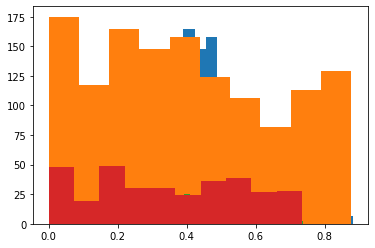

In [5]:
def EqualizeHistogram(a, bins):
    a = np.array(a)
    hist, bins2 = np.histogram(a, bins=bins)

    #Compute CDF from histogram
    cdf = np.cumsum(hist, dtype=np.float64)
    cdf = np.hstack(([0], cdf))
    cdf = cdf / cdf[-1]

    #Do equalization
    binnum = np.digitize(a, bins, True)-1
    neg = np.where(binnum < 0)
    binnum[neg] = 0

    aeq = cdf[binnum] * bins[-1]

    return aeq


#let's perform a simple equalization

n, bins,_ = plt.hist(Prob_train,bins = 20)

prob_eq = EqualizeHistogram(Prob_train,bins)

plt.hist(prob_eq)

print(prob_eq.shape)


#---------------------
n, bins,_ = plt.hist(Prob_test,bins = 30)

prob_test_eq = EqualizeHistogram(Prob_test,bins)

plt.hist(prob_test_eq)

print(prob_test_eq.shape)

- Como observamos el el histograma, los **datos están desbalanceados**.

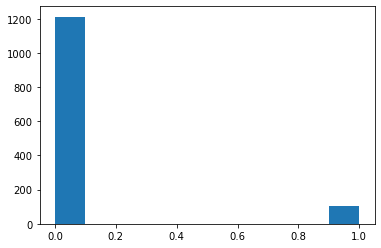

In [6]:
plt.hist(y_train)
plt.show()

In [7]:
X_train_1 = X_train[:,0,:]
X_train_2 = X_train[:,1,:]

Vamos a hacer lo siguiente en la función:

1. Revisar si hay alguna característica que tenga más del 50% a NaN, entonces habría que considerar eliminarla. Tenemos un problema, porque hay que revisar que tengo más de 50% en todas las revisiones. Para no complicar las cosas, vamos a considerar que trabajamos sólo con tres revisiones (vamos a ver si llegamos rápido a ese punto, en otro caso deberíamos ver si paramos en tres revisiones, que ya es bastante).

1. Revisar si hay algún paciente con más de 8 características NaN, con que esto ocurra en cualquiera de las tres revisiones, deberíamos considerarlo que se elimina, en todas las revisiones.

## 1.1 Features con problemas:

Revisando la información rápidamente hay varias features con problemas:

1. **Importante**: las variables *Blood_Glucose* y *Glycated-HB* hay que sacarlas fuera de la base de datos, porque son las que se utilizan para determinar si un pacientes diabético o no.
1. Hay cuatro variables que tiene muchos NaN, así que lo que intentaría sería centrarnos en cómo imputarlas, tanto en training como en test. Esto es un poco más complicado de lo que hacemos habitualmente con las bases de datos normales, porque aquí tenemos más datos y de forma un poco más complicada.
    * HOMA
    * Insulin
    * Vitamin-D
   
Estas son las que más tienen en las tres primeras revisiones. Lo que vamos a hacer es lo siguiente, aprovechando que tenemos un montón de datos y datos temporales vamos a utilizar un esquema diferente para hacer la imputación de forma que sea más razonable, intentando perder el menor número de datos posibles, por ejemplo: 
 * Regresión lineal múltiple con respecto a todas las variables temporales. Otra cosa
 * Verificar cuál es la correlación entre variables, para una misma revisión, y buscar con las que mayor correlación tengan y proponer un modelo de regresión lineal. 
 
Mi propuesta para el TFG: 
 * Vamos a hacer imputación por la mediana (en el caso de Vitamin-D, HOMA e Insulin) casi seguro que vamos a empeorar un poco porque hay muchos NaN, pero la esperanza es que todo se compense.
 * Si te ves con fuerzas y ganas probamos lo que he comentado anteriormente



In [8]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
df = pd.DataFrame(X_train_2,columns = feature_names[:-1])

In [9]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)

Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
Blood_Glucose 3
Glycated-HB 650
PCR 132
Vitamin-D 993


In [10]:
def data_nan_review_analysis(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

Creamos una nueva variable: **X_train_imp**, obtenida de aplicar la función imputing_data a X_train. Devuelve lo siguiente

- Nº de revisión
- Features
- Features con sus respectivos NaN (no aparecen las features eliminadas previamente por la función)

In [11]:
X_train_imp = imputing_data(X_train)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
PCR 231
Vitamin-D 1079
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
PCR 132
Vitamin-D 993
----------
----------
review 2
--

In [12]:
#review imputed data #Values for Revision 1 for vitamin D
#X_train_imp[1]['Vitamin-D']

- Obtenemos las **dos primeras revisiones** ya que nos es más sencillo trabajar. El resultado obtenido será extrapolable a un mayor número de revisiones.

In [13]:
#Get the two first reviews

X_train_1 = X_train_imp[0]
X_train_2 = X_train_imp[1]

print(X_train_2.shape)

(1317, 20)


In [14]:
newX_train = np.concatenate((X_train_2, Prob_train[:,np.newaxis]), axis=1)
#newX_train = np.concatenate((X_train_2, prob_eq[:,np.newaxis]), axis=1)

print(newX_train.shape)

(1317, 21)


### Undersampling:

Las técnicas de *undersampling* eliminan ejemplos del conjunto de datos de entrenamiento que pertenecen a la clase mayoritaria para equilibrar mejor la distribución de clases.

La técnica de submuestreo más simple implica la selección aleatoria de ejemplos de la clase mayoritaria y su eliminación del conjunto de datos de entrenamiento. Esto se conoce como submuestreo aleatorio. Aunque simple y eficaz, una limitación de esta técnica es que los ejemplos se eliminan sin preocuparse por su utilidad o importancia para determinar el límite de decisión entre las clases. Esto significa que es posible, o incluso probable, que se elimine información útil.

Una extensión de este enfoque es ser más exigente con respecto a los ejemplos de la clase mayoritaria que se eliminan. Por lo general, se trata de modelos heurísticos o de aprendizaje que intentan identificar ejemplos redundantes para la eliminación o ejemplos útiles para la no eliminación

# 2. PREDICCIÓN

### 2.1 Random Forest

Debemos probar una amplia gama de valores y ver qué funciona. Intentaremos ajustar el siguiente conjunto de hiperparámetros:

- max_features = max number of features considered for splitting a node
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

Para usar **RandomizedSearchCV**, primero necesitamos crear una cuadrícula de parámetros para muestrear durante el ajuste:

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


En cada iteración, el algoritmo elegirá una combinación diferente de las características. El beneficio de una búsqueda aleatoria es que no probamos todas las combinaciones, sino que seleccionamos al azar para muestrear una amplia gama de valores.

**Grid Search**

GridSearchCV es una clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar, puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada.

- cv, que es el número de pliegues que se deben usar para la validación cruzada. 

Más pliegues de cv reducen las posibilidades de sobreajuste, pero aumentarlo aumentará el tiempo de ejecución.

**Balanced Random Forest** es una modificación de RF, donde por cada árbol se construyen dos conjuntos bootstrap del mismo tamaño, igual al tamaño de la clase minoritaria: uno para la clase minoritaria, el otro para la clase mayoritaria. Conjuntamente, estos dos conjuntos constituyen el conjunto de entrenamiento.

In [16]:
# First create the base model to tune

#Creo que es mejor la estrategia que se presenta en from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf_1 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [17]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_1, random_grid, cv=7 , n_jobs = 1, verbose = 3)

In [19]:
# Fit the random search model
#grid_random.fit(X_resampled, y_resampled)
grid_random.fit(newX_train, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits
[CV 1/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.979 total time=   0.2s
[CV 2/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 3/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.984 total time=   0.1s
[CV 7/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=1.000 total time=   0.1s
[CV 1/7] END max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.995 total time= 

[CV 3/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.989 total time=   0.1s
[CV 7/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 3/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.963 total time=   0.1s
[CV 5/7] END max_features=auto, min_samples_le

[CV 4/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.963 total time=   0.1s
[CV 5/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.989 total time=   0.1s
[CV 7/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.979 total time=   0.1s
[CV 2/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 3/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.963 total time=   0.1s
[CV 5/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=auto, min_sampl

[CV 5/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.968 total time=   0.2s
[CV 6/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.984 total time=   0.1s
[CV 7/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=1.000 total time=   0.1s
[CV 1/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.979 total time=   0.1s
[CV 2/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 3/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.989 total time=   0.1s
[CV 7/7] END max_features=sqrt, min_samples_leaf=2, min

[CV 7/7] END max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.979 total time=   0.1s
[CV 2/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.989 total time=   0.1s
[CV 3/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.973 total time=   0.1s
[CV 6/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.984 total time=   0.1s
[CV 7/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=5;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=sqrt, min_samples_l

[CV 1/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.974 total time=   0.2s
[CV 2/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.995 total time=   0.2s
[CV 3/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.995 total time=   0.2s
[CV 4/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.968 total time=   0.2s
[CV 5/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.968 total time=   0.2s
[CV 6/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.979 total time=   0.2s
[CV 7/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.995 total time=   0.2s
[CV 1/7] END max_features=sqrt, min_samples_leaf=20, min_samples_split=2;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=sqrt, min_samples_leaf=20, min_samples_split=2;, score=0.989 total time=   0.1s
[CV 3/7] END max_features=sqrt, min_sam

[CV 2/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.989 total time=   0.1s
[CV 3/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.989 total time=   0.1s
[CV 7/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=log2, min_samples_leaf=4, min_samples_split=10;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=log2, min_samples_leaf=4, min_samples_split=10;, score=0.989 total time=   0.1s
[CV 3/7] END max_features=log2, min_samples_leaf=4, min_samples_split=10;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=log2, min_samples_leaf=4, 

[CV 3/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 4/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.963 total time=   0.1s
[CV 5/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.973 total time=   0.1s
[CV 6/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.984 total time=   0.1s
[CV 7/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.995 total time=   0.1s
[CV 1/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.974 total time=   0.1s
[CV 2/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.995 total time=   0.1s
[CV 3/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.989 total time=   0.1s
[CV 4/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=log2, min_samples_le

[CV 4/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.968 total time=   0.1s
[CV 5/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.968 total time=   0.1s
[CV 6/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.989 total time=   0.1s
[CV 7/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.995 total time=   0.1s


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=50),
             n_jobs=1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [20]:
grid_random.best_params_

{'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 5}

Creamos un **nuevo modelo** teniendo en cuenta los hiperparámetros que nos devuelve Grid_Search

In [21]:
rf_2 = BalancedRandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample',n_jobs=-1,verbose = 3)

In [22]:
rf_2.fit(newX_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 7 of 5000
building tree 1 of 5000
building tree 6 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 8 of 5000
building tree 5 of 5000
building tree 4 of 5000
building tree 9 of 5000
building tree 10 of 5000building tree 11 of 5000
building tree 14 of 5000building tree 12 of 5000

building tree 15 of 5000

building tree 16 of 5000
building tree 13 of 5000
building tree 17 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 18 of 5000
building tree 21 of 5000
building tree 24 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 30 of 5000building tree 27 of 5000

building tree 28 of 5000building tree 29 of 5000

building tree 33 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 37 of 5000
building tree 35 of 5000building tree 34 of 5000building tree 36 of 5000


building tree 38 of 5000building tree 39 of 5000
building tree 40 of 5000

building 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s


building tree 153 of 5000building tree 151 of 5000

building tree 149 of 5000
building tree 154 of 5000
building tree 150 of 5000
building tree 152 of 5000
building tree 155 of 5000
building tree 156 of 5000
building tree 158 of 5000building tree 157 of 5000building tree 160 of 5000


building tree 159 of 5000
building tree 161 of 5000
building tree 163 of 5000
building tree 162 of 5000
building tree 164 of 5000
building tree 166 of 5000
building tree 165 of 5000
building tree 167 of 5000
building tree 168 of 5000
building tree 170 of 5000
building tree 169 of 5000
building tree 171 of 5000
building tree 172 of 5000
building tree 173 of 5000
building tree 174 of 5000building tree 177 of 5000

building tree 175 of 5000
building tree 176 of 5000
building tree 180 of 5000building tree 178 of 5000

building tree 179 of 5000
building tree 181 of 5000
building tree 182 of 5000
building tree 183 of 5000
building tree 186 of 5000
building tree 187 of 5000
building tree 184 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.8s


building tree 291 of 5000
building tree 292 of 5000building tree 294 of 5000

building tree 293 of 5000
building tree 295 of 5000
building tree 297 of 5000
building tree 296 of 5000
building tree 299 of 5000building tree 298 of 5000building tree 300 of 5000


building tree 303 of 5000
building tree 302 of 5000
building tree 301 of 5000
building tree 304 of 5000
building tree 305 of 5000
building tree 306 of 5000
building tree 309 of 5000building tree 307 of 5000

building tree 308 of 5000
building tree 312 of 5000
building tree 311 of 5000building tree 310 of 5000

building tree 313 of 5000
building tree 314 of 5000
building tree 315 of 5000
building tree 316 of 5000
building tree 318 of 5000building tree 317 of 5000

building tree 320 of 5000
building tree 319 of 5000building tree 321 of 5000

building tree 323 of 5000
building tree 322 of 5000
building tree 325 of 5000building tree 326 of 5000

building tree 324 of 5000
building tree 327 of 5000
building tree 328 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.5s


building tree 565 of 5000
building tree 567 of 5000
building tree 566 of 5000
building tree 568 of 5000
building tree 569 of 5000
building tree 570 of 5000
building tree 572 of 5000
building tree 571 of 5000building tree 573 of 5000

building tree 574 of 5000
building tree 575 of 5000
building tree 576 of 5000
building tree 577 of 5000
building tree 580 of 5000building tree 579 of 5000
building tree 578 of 5000building tree 582 of 5000


building tree 581 of 5000
building tree 583 of 5000
building tree 585 of 5000
building tree 584 of 5000
building tree 587 of 5000building tree 586 of 5000

building tree 588 of 5000
building tree 589 of 5000
building tree 590 of 5000
building tree 593 of 5000building tree 592 of 5000

building tree 591 of 5000
building tree 595 of 5000
building tree 596 of 5000
building tree 594 of 5000
building tree 597 of 5000
building tree 599 of 5000
building tree 600 of 5000
building tree 601 of 5000
building tree 598 of 5000
building tree 602 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s


building tree 846 of 5000
building tree 852 of 5000
building tree 848 of 5000
building tree 850 of 5000building tree 851 of 5000
building tree 849 of 5000

building tree 853 of 5000
building tree 854 of 5000
building tree 855 of 5000
building tree 857 of 5000building tree 856 of 5000

building tree 858 of 5000building tree 861 of 5000
building tree 859 of 5000

building tree 860 of 5000
building tree 862 of 5000
building tree 864 of 5000building tree 865 of 5000

building tree 863 of 5000
building tree 867 of 5000
building tree 866 of 5000
building tree 869 of 5000
building tree 868 of 5000
building tree 870 of 5000
building tree 871 of 5000
building tree 872 of 5000
building tree 875 of 5000building tree 873 of 5000

building tree 874 of 5000
building tree 876 of 5000
building tree 878 of 5000
building tree 880 of 5000building tree 879 of 5000

building tree 881 of 5000
building tree 877 of 5000
building tree 883 of 5000
building tree 882 of 5000
building tree 884 of 5000building tree

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:    3.4s


building tree 1185 of 5000
building tree 1184 of 5000
building tree 1183 of 5000building tree 1182 of 5000
building tree 1186 of 5000

building tree 1187 of 5000
building tree 1188 of 5000
building tree 1191 of 5000
building tree 1190 of 5000
building tree 1192 of 5000
building tree 1189 of 5000
building tree 1193 of 5000
building tree 1196 of 5000building tree 1194 of 5000

building tree 1195 of 5000
building tree 1197 of 5000
building tree 1198 of 5000
building tree 1199 of 5000
building tree 1200 of 5000
building tree 1202 of 5000
building tree 1201 of 5000
building tree 1203 of 5000
building tree 1204 of 5000building tree 1206 of 5000

building tree 1207 of 5000building tree 1205 of 5000

building tree 1209 of 5000
building tree 1211 of 5000building tree 1208 of 5000
building tree 1210 of 5000

building tree 1212 of 5000
building tree 1213 of 5000
building tree 1214 of 5000
building tree 1215 of 5000building tree 1216 of 5000

building tree 1218 of 5000
building tree 1217 of 5000
b

building tree 1512 of 5000building tree 1517 of 5000

building tree 1516 of 5000
building tree 1518 of 5000
building tree 1519 of 5000
building tree 1520 of 5000building tree 1521 of 5000

building tree 1522 of 5000
building tree 1525 of 5000
building tree 1523 of 5000
building tree 1524 of 5000
building tree 1527 of 5000
building tree 1528 of 5000
building tree 1526 of 5000
building tree 1529 of 5000
building tree 1531 of 5000
building tree 1530 of 5000
building tree 1533 of 5000building tree 1532 of 5000

building tree 1534 of 5000building tree 1536 of 5000

building tree 1535 of 5000
building tree 1537 of 5000
building tree 1538 of 5000
building tree 1539 of 5000
building tree 1540 of 5000
building tree 1541 of 5000
building tree 1543 of 5000
building tree 1542 of 5000
building tree 1544 of 5000
building tree 1545 of 5000
building tree 1547 of 5000building tree 1546 of 5000

building tree 1548 of 5000building tree 1549 of 5000

building tree 1551 of 5000
building tree 1552 of 5000
b

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    4.7s


building tree 1584 of 5000
building tree 1586 of 5000
building tree 1585 of 5000
building tree 1587 of 5000
building tree 1590 of 5000
building tree 1589 of 5000
building tree 1591 of 5000
building tree 1588 of 5000
building tree 1593 of 5000
building tree 1592 of 5000
building tree 1595 of 5000
building tree 1597 of 5000building tree 1598 of 5000

building tree 1594 of 5000building tree 1599 of 5000

building tree 1596 of 5000
building tree 1600 of 5000
building tree 1601 of 5000
building tree 1602 of 5000
building tree 1603 of 5000
building tree 1605 of 5000
building tree 1604 of 5000
building tree 1606 of 5000
building tree 1608 of 5000
building tree 1607 of 5000
building tree 1610 of 5000
building tree 1609 of 5000
building tree 1612 of 5000building tree 1611 of 5000
building tree 1613 of 5000
building tree 1614 of 5000

building tree 1615 of 5000
building tree 1616 of 5000
building tree 1617 of 5000
building tree 1619 of 5000
building tree 1618 of 5000
building tree 1620 of 5000
b

building tree 1929 of 5000building tree 1930 of 5000

building tree 1931 of 5000
building tree 1935 of 5000
building tree 1934 of 5000
building tree 1932 of 5000building tree 1933 of 5000

building tree 1936 of 5000
building tree 1937 of 5000
building tree 1941 of 5000
building tree 1938 of 5000
building tree 1939 of 5000
building tree 1940 of 5000building tree 1942 of 5000

building tree 1944 of 5000
building tree 1943 of 5000
building tree 1947 of 5000building tree 1946 of 5000

building tree 1950 of 5000
building tree 1948 of 5000
building tree 1945 of 5000
building tree 1949 of 5000
building tree 1951 of 5000
building tree 1952 of 5000
building tree 1953 of 5000
building tree 1954 of 5000
building tree 1955 of 5000
building tree 1956 of 5000
building tree 1957 of 5000
building tree 1958 of 5000
building tree 1959 of 5000
building tree 1961 of 5000
building tree 1963 of 5000
building tree 1960 of 5000
building tree 1962 of 5000
building tree 1964 of 5000
building tree 1965 of 5000
b

[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    6.1s


building tree 2063 of 5000
building tree 2064 of 5000
building tree 2065 of 5000
building tree 2067 of 5000
building tree 2066 of 5000
building tree 2068 of 5000building tree 2069 of 5000

building tree 2070 of 5000
building tree 2072 of 5000
building tree 2075 of 5000
building tree 2071 of 5000
building tree 2074 of 5000
building tree 2073 of 5000
building tree 2076 of 5000
building tree 2078 of 5000
building tree 2077 of 5000
building tree 2079 of 5000building tree 2081 of 5000

building tree 2080 of 5000
building tree 2083 of 5000building tree 2082 of 5000

building tree 2085 of 5000
building tree 2084 of 5000
building tree 2086 of 5000
building tree 2087 of 5000
building tree 2088 of 5000
building tree 2089 of 5000
building tree 2090 of 5000
building tree 2091 of 5000
building tree 2092 of 5000building tree 2094 of 5000

building tree 2093 of 5000
building tree 2095 of 5000
building tree 2096 of 5000
building tree 2097 of 5000
building tree 2098 of 5000
building tree 2100 of 5000bu

building tree 2399 of 5000building tree 2400 of 5000

building tree 2401 of 5000
building tree 2402 of 5000
building tree 2404 of 5000
building tree 2405 of 5000
building tree 2403 of 5000
building tree 2406 of 5000
building tree 2408 of 5000
building tree 2407 of 5000
building tree 2409 of 5000
building tree 2412 of 5000
building tree 2410 of 5000building tree 2411 of 5000

building tree 2414 of 5000
building tree 2413 of 5000
building tree 2415 of 5000
building tree 2416 of 5000building tree 2417 of 5000

building tree 2418 of 5000
building tree 2419 of 5000building tree 2420 of 5000

building tree 2422 of 5000building tree 2421 of 5000

building tree 2423 of 5000
building tree 2425 of 5000
building tree 2424 of 5000
building tree 2426 of 5000building tree 2427 of 5000

building tree 2429 of 5000
building tree 2428 of 5000
building tree 2431 of 5000
building tree 2430 of 5000
building tree 2432 of 5000
building tree 2434 of 5000
building tree 2433 of 5000
building tree 2436 of 5000bu

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:    7.8s


building tree 2590 of 5000
building tree 2592 of 5000
building tree 2593 of 5000
building tree 2594 of 5000
building tree 2595 of 5000
building tree 2596 of 5000
building tree 2598 of 5000
building tree 2597 of 5000
building tree 2600 of 5000
building tree 2599 of 5000
building tree 2601 of 5000
building tree 2602 of 5000
building tree 2603 of 5000
building tree 2604 of 5000
building tree 2608 of 5000
building tree 2605 of 5000building tree 2610 of 5000

building tree 2606 of 5000building tree 2609 of 5000building tree 2607 of 5000


building tree 2612 of 5000
building tree 2613 of 5000
building tree 2611 of 5000
building tree 2614 of 5000
building tree 2616 of 5000
building tree 2615 of 5000
building tree 2618 of 5000
building tree 2617 of 5000
building tree 2621 of 5000
building tree 2619 of 5000building tree 2620 of 5000

building tree 2622 of 5000building tree 2623 of 5000

building tree 2624 of 5000
building tree 2626 of 5000
building tree 2627 of 5000building tree 2631 of 5000

b

building tree 2939 of 5000
building tree 2940 of 5000
building tree 2941 of 5000
building tree 2942 of 5000
building tree 2943 of 5000
building tree 2945 of 5000
building tree 2944 of 5000building tree 2946 of 5000

building tree 2947 of 5000
building tree 2950 of 5000
building tree 2949 of 5000
building tree 2948 of 5000
building tree 2952 of 5000
building tree 2951 of 5000
building tree 2955 of 5000
building tree 2954 of 5000
building tree 2953 of 5000building tree 2957 of 5000

building tree 2956 of 5000
building tree 2958 of 5000
building tree 2959 of 5000
building tree 2960 of 5000
building tree 2962 of 5000
building tree 2961 of 5000
building tree 2965 of 5000
building tree 2963 of 5000
building tree 2964 of 5000
building tree 2968 of 5000
building tree 2966 of 5000
building tree 2967 of 5000
building tree 2970 of 5000
building tree 2969 of 5000
building tree 2972 of 5000
building tree 2973 of 5000building tree 2971 of 5000
building tree 2974 of 5000

building tree 2975 of 5000
b

[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    9.7s


building tree 3238 of 5000building tree 3240 of 5000

building tree 3241 of 5000
building tree 3242 of 5000
building tree 3239 of 5000
building tree 3243 of 5000
building tree 3245 of 5000
building tree 3247 of 5000building tree 3244 of 5000building tree 3248 of 5000


building tree 3246 of 5000building tree 3249 of 5000

building tree 3250 of 5000
building tree 3254 of 5000building tree 3252 of 5000building tree 3253 of 5000


building tree 3251 of 5000
building tree 3255 of 5000
building tree 3257 of 5000building tree 3256 of 5000

building tree 3258 of 5000
building tree 3261 of 5000
building tree 3260 of 5000
building tree 3263 of 5000
building tree 3259 of 5000
building tree 3266 of 5000
building tree 3265 of 5000
building tree 3264 of 5000building tree 3262 of 5000

building tree 3267 of 5000
building tree 3268 of 5000
building tree 3270 of 5000building tree 3269 of 5000

building tree 3272 of 5000
building tree 3271 of 5000building tree 3273 of 5000

building tree 3274 of 5000
b

building tree 3581 of 5000

building tree 3582 of 5000
building tree 3586 of 5000
building tree 3585 of 5000
building tree 3584 of 5000
building tree 3588 of 5000building tree 3583 of 5000building tree 3587 of 5000


building tree 3589 of 5000
building tree 3591 of 5000
building tree 3590 of 5000
building tree 3592 of 5000
building tree 3593 of 5000
building tree 3596 of 5000
building tree 3597 of 5000
building tree 3595 of 5000
building tree 3594 of 5000
building tree 3598 of 5000
building tree 3599 of 5000building tree 3600 of 5000

building tree 3601 of 5000
building tree 3602 of 5000
building tree 3603 of 5000
building tree 3604 of 5000building tree 3605 of 5000

building tree 3606 of 5000
building tree 3607 of 5000
building tree 3610 of 5000
building tree 3609 of 5000
building tree 3611 of 5000
building tree 3608 of 5000
building tree 3615 of 5000
building tree 3612 of 5000building tree 3614 of 5000

building tree 3613 of 5000
building tree 3616 of 5000
building tree 3621 of 5000


[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed:   11.8s


building tree 3916 of 5000building tree 3915 of 5000

building tree 3917 of 5000
building tree 3919 of 5000building tree 3918 of 5000

building tree 3920 of 5000building tree 3922 of 5000building tree 3921 of 5000


building tree 3923 of 5000
building tree 3924 of 5000
building tree 3925 of 5000
building tree 3926 of 5000building tree 3928 of 5000

building tree 3927 of 5000
building tree 3930 of 5000
building tree 3929 of 5000
building tree 3931 of 5000
building tree 3932 of 5000
building tree 3933 of 5000
building tree 3934 of 5000
building tree 3935 of 5000
building tree 3936 of 5000
building tree 3937 of 5000
building tree 3938 of 5000
building tree 3939 of 5000
building tree 3942 of 5000
building tree 3940 of 5000
building tree 3941 of 5000
building tree 3943 of 5000building tree 3944 of 5000

building tree 3945 of 5000
building tree 3946 of 5000
building tree 3947 of 5000
building tree 3948 of 5000
building tree 3949 of 5000building tree 3950 of 5000

building tree 3951 of 5000
b

building tree 4251 of 5000
building tree 4252 of 5000building tree 4253 of 5000

building tree 4255 of 5000
building tree 4256 of 5000
building tree 4254 of 5000
building tree 4257 of 5000
building tree 4258 of 5000
building tree 4259 of 5000
building tree 4260 of 5000
building tree 4261 of 5000
building tree 4262 of 5000
building tree 4263 of 5000
building tree 4264 of 5000
building tree 4266 of 5000
building tree 4265 of 5000building tree 4268 of 5000
building tree 4267 of 5000

building tree 4269 of 5000
building tree 4270 of 5000
building tree 4271 of 5000
building tree 4275 of 5000building tree 4272 of 5000building tree 4276 of 5000


building tree 4274 of 5000
building tree 4277 of 5000
building tree 4273 of 5000
building tree 4278 of 5000building tree 4279 of 5000

building tree 4280 of 5000
building tree 4282 of 5000building tree 4281 of 5000

building tree 4283 of 5000
building tree 4285 of 5000
building tree 4284 of 5000
building tree 4286 of 5000
building tree 4287 of 5000
b

building tree 4576 of 5000
building tree 4577 of 5000building tree 4578 of 5000

building tree 4580 of 5000
building tree 4579 of 5000
building tree 4582 of 5000
building tree 4581 of 5000
building tree 4583 of 5000
building tree 4584 of 5000building tree 4586 of 5000
building tree 4587 of 5000

building tree 4585 of 5000building tree 4588 of 5000

building tree 4591 of 5000
building tree 4590 of 5000
building tree 4589 of 5000
building tree 4592 of 5000
building tree 4593 of 5000building tree 4594 of 5000

building tree 4596 of 5000building tree 4595 of 5000

building tree 4597 of 5000
building tree 4598 of 5000
building tree 4599 of 5000building tree 4600 of 5000

building tree 4603 of 5000
building tree 4602 of 5000
building tree 4605 of 5000
building tree 4601 of 5000
building tree 4606 of 5000
building tree 4604 of 5000
building tree 4608 of 5000
building tree 4607 of 5000building tree 4609 of 5000

building tree 4611 of 5000
building tree 4610 of 5000
building tree 4613 of 5000
b

[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:   14.0s


building tree 4645 of 5000building tree 4643 of 5000

building tree 4646 of 5000
building tree 4647 of 5000
building tree 4649 of 5000building tree 4648 of 5000

building tree 4650 of 5000
building tree 4651 of 5000
building tree 4652 of 5000
building tree 4653 of 5000
building tree 4654 of 5000building tree 4657 of 5000building tree 4658 of 5000


building tree 4656 of 5000building tree 4655 of 5000

building tree 4659 of 5000
building tree 4660 of 5000building tree 4661 of 5000

building tree 4665 of 5000
building tree 4664 of 5000
building tree 4662 of 5000building tree 4663 of 5000

building tree 4666 of 5000
building tree 4667 of 5000
building tree 4669 of 5000
building tree 4670 of 5000
building tree 4668 of 5000
building tree 4671 of 5000building tree 4672 of 5000

building tree 4673 of 5000building tree 4674 of 5000

building tree 4675 of 5000
building tree 4676 of 5000
building tree 4677 of 5000
building tree 4678 of 5000building tree 4680 of 5000

building tree 4679 of 5000
b

[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   15.2s finished


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               min_samples_leaf=14, min_samples_split=5,
                               n_estimators=5000, n_jobs=-1, verbose=3)

In [23]:
y_pred = rf_2.predict(newX_train)
print(y_pred)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:    0.8s


[0 1 0 ... 0 0 0]


[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    1.1s finished


In [24]:
y_pred_prob = rf_2.predict_proba(newX_train)
print(y_pred_prob)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:    1.0s


[[0.80833955 0.19166045]
 [0.2435146  0.7564854 ]
 [0.68057627 0.31942373]
 ...
 [0.70386771 0.29613229]
 [0.75371095 0.24628905]
 [0.67517209 0.32482791]]


[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    1.1s finished


## Ojo que vuelves a salvar Probabilidades train

**De forma que si vuelves a correr el código, ahora utilizarías las probabilidades de train de la misma revisión** Esto habría que afinarlo un poco más porque me parece que está haciendo que funcione mal.

In [25]:
#np.save('Probabilidades train', y_pred_prob[:,1])

## 2.2 Prestaciones

La **sensibilidad y la especificidad** son dos valores que nos indican la capacidad de nuestro estimador para discriminar los casos positivos, de los negativos. La sensibilidad es la fracción de verdaderos positivos, mientras que la especificidad, es la fracción de verdaderos negativos.

-  **La sensibilidad** es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.
-  **La especificidad** se trata de los casos negativos que el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase.
- **La Precisión** se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción entre el número de predicciones correctas (tanto positivas como negativas) y el total de predicciones. En forma práctica es  el porcentaje de casos positivos detectados.


### Prestaciones en train

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    1.1s finished


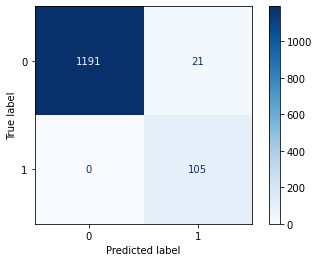

Accuracy :  0.9840546697038725
Sensitivity :  1.0
Specificity :  0.9826732673267327
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      1.00      0.99      0.99      0.98      1212
          1       0.83      1.00      0.98      0.91      0.99      0.98       105

avg / total       0.99      0.98      1.00      0.98      0.99      0.98      1317



In [27]:
#cm = confusion_matrix(y_train_adasyn,y_pred)
cm = confusion_matrix(y_train,y_pred)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_2,newX_train,y_train,cmap=plt.cm.Blues)

plt.show()

total1=sum(sum(cm))

accuracy1=(cm[0,0]+cm[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_train, y_pred))

### Prestaciones en test

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  1

[[0.72458768 0.27541232]
 [0.68530336 0.31469664]
 [0.31498932 0.68501068]
 [0.78407405 0.21592595]
 [0.68671245 0.31328755]
 [0.81679484 0.18320516]
 [0.76308974 0.23691026]
 [0.51951599 0.48048401]
 [0.67906717 0.32093283]
 [0.22812944 0.77187056]
 [0.76089937 0.23910063]
 [0.75281388 0.24718612]
 [0.7734284  0.2265716 ]
 [0.77057923 0.22942077]
 [0.22186686 0.77813314]
 [0.74799701 0.25200299]
 [0.79520941 0.20479059]
 [0.75186067 0.24813933]
 [0.75973751 0.24026249]
 [0.7862306  0.2137694 ]
 [0.72419077 0.27580923]
 [0.72843234 0.27156766]
 [0.28736695 0.71263305]
 [0.77001793 0.22998207]
 [0.73187663 0.26812337]
 [0.71829027 0.28170973]
 [0.78610142 0.21389858]
 [0.76963    0.23037   ]
 [0.73476    0.26524   ]
 [0.74735523 0.25264477]
 [0.77115726 0.22884274]
 [0.7540767  0.2459233 ]
 [0.75722251 0.24277749]
 [0.79601813 0.20398187]
 [0.81732626 0.18267374]
 [0.73669022 0.26330978]
 [0.71588157 0.28411843]
 [0.74488957 0.25511043]
 [0.77843554 0.22156446]
 [0.28056969 0.71943031]


[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 3856 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 4592 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed:    1.0s finished


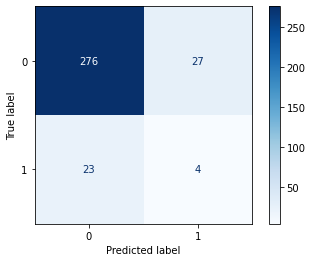

In [28]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_2 = pd.DataFrame(X_test[:,1,:],columns = feature_names[:-1])

X_test_2 = X_test_2.drop('Blood_Glucose',axis = 1)
X_test_2 = X_test_2.drop('Glycated-HB',axis = 1)

#impute

X_test_2 = X_test_2.fillna(X_train_2.median())
#newX_test = np.concatenate((X_test_2, Prob_test[:,None]), axis=1)
newX_test = np.concatenate((X_test_2, prob_test_eq[:,np.newaxis]), axis=1)

y_pred_test = rf_2.predict(newX_test)
y_pred_test_prob = rf_2.predict_proba(newX_test)

print(y_pred_test_prob)

plot_confusion_matrix(rf_2,newX_test,y_test,cmap=plt.cm.Blues)

plt.show()

In [29]:
cm1 = confusion_matrix(y_test,y_pred_test)

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)

Accuracy :  0.8484848484848485
Specificity :  0.9108910891089109
Sensitivity :  0.14814814814814814


# Aplicamos el modelo eliminando las variables Vitamin-D, HOMA e Insulin

# 1. PREPROCESADO

In [30]:
def data_nan_review_analysis_1(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('HOMA',axis = 1)
    df = df.drop('Insulin',axis = 1)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    df = df.drop('Vitamin-D',axis = 1)
    
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data_1(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis_1(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

In [31]:
X_train_imp_1 = imputing_data_1(X_train)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
PCR 231
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
PCR 132
----------
----------
review 2
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin

In [32]:
#Get the two first reviews

X_train_11 = X_train_imp_1[0]
X_train_22 = X_train_imp_1[1]

In [33]:
newX_train_1 = np.concatenate((X_train_22, Prob_train_1[:,None]), axis=1)

# 2. PREDICCIÓN

## 2.1 Random Forest

In [34]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


In [35]:
# First create the base model to tune
rf_11 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [36]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_11, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [37]:
# Fit the random search model
grid_random.fit(newX_train_1, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=50),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=5)

In [38]:
grid_random.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

### Rebalancea dentro de cada árbol

In [39]:
rf_22 = BalancedRandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [40]:
rf_22.fit(newX_train_1, y_train)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='sqrt', n_estimators=5000)

In [41]:
y_pred_1 = rf_22.predict(newX_train_1)
y_pred_1_prob = rf_22.predict_proba(newX_train_1)
print(y_pred_1)
print(y_pred_1_prob)

[0 1 0 ... 0 0 0]
[[0.88   0.12  ]
 [0.0442 0.9558]
 [0.8536 0.1464]
 ...
 [0.8456 0.1544]
 [0.8266 0.1734]
 [0.8464 0.1536]]


## 2.2 Calibración de la probabilidad

In [42]:
'''from sklearn.calibration import CalibratedClassifierCV

base_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

#vamos a calibrar training
calibrated_clf = CalibratedClassifierCV(base_estimator=rf_22,cv='prefit', method = 'sigmoid',ensemble = False)

calibrated_clf.fit(X_train_11, y_train)'''

"from sklearn.calibration import CalibratedClassifierCV\n\nbase_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],\n                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    \n                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')\n\n#vamos a calibrar training\ncalibrated_clf = CalibratedClassifierCV(base_estimator=rf_22,cv='prefit', method = 'sigmoid',ensemble = False)\n\ncalibrated_clf.fit(X_train_11, y_train)"

In [43]:
'''#calibrated_clf.
from sklearn.calibration import calibration_curve

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
X_test_1 = X_test_1.drop('HOMA',axis = 1)
X_test_1 = X_test_1.drop('Insulin',axis = 1)
X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)

X_test_1 = X_test_1.fillna(X_train_1.median())


y_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]

y_train_cali = calibrated_clf.predict_proba(X_train_11)[:,1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=10)
fraction_of_positives_train, mean_predicted_value_train = calibration_curve(y_train, y_train_cali, n_bins=10)

plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot(mean_predicted_value_train, fraction_of_positives_train, "^-")


plt.figure()
plt.hist(y_pred_cali, range=(0, 1), bins=10,histtype="step", lw=2)
plt.hist(y_train_cali, range=(0, 1), bins=10,histtype="step", lw=2)


plt.hist(rf_22.predict_proba(X_train_11)[:,1],bins = 10,histtype='step')'''

'#calibrated_clf.\nfrom sklearn.calibration import calibration_curve\n\nfeature_names = [\'Age\',\'Weight\',\'Size\',\'IMC\',\'Creatinine\',\'Cystatin\',\'HDL\',\'LDL\',\'Triglyciredes\',\'GOT\',\'GPT\',\'GGT\',\'Albuminuria\',\'Ferritin\',\'HOMA\',\'Insulin\',\'Blood_Glucose\',\'Glycated-HB\',\'PCR\',\'Vitamin-D\',\'TAS\',\'TAD\',\'Date\']\n\nX_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])\n\nX_test_1 = X_test_1.drop(\'Blood_Glucose\',axis = 1)\nX_test_1 = X_test_1.drop(\'Glycated-HB\',axis = 1)\nX_test_1 = X_test_1.drop(\'HOMA\',axis = 1)\nX_test_1 = X_test_1.drop(\'Insulin\',axis = 1)\nX_test_1 = X_test_1.drop(\'Vitamin-D\',axis = 1)\n\nX_test_1 = X_test_1.fillna(X_train_1.median())\n\n\ny_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]\n\ny_train_cali = calibrated_clf.predict_proba(X_train_11)[:,1]\n\nfraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=10)\nfraction_of_positives_train, mean_predicted_value_train = 

## 2.3 Prestaciones

### Prestaciones en train

In [44]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[[1126   86]
 [   0  105]]


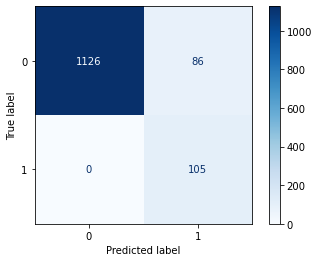

Accuracy :  0.9347000759301443
Sensitivity :  1.0
Specificity :  0.929042904290429


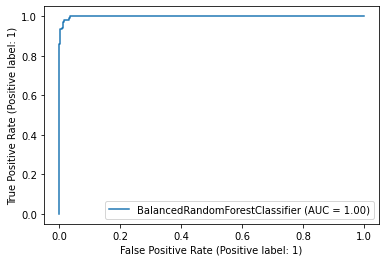

In [45]:
#cm = confusion_matrix(y_train_adasyn,y_pred)

cm = confusion_matrix(y_train,y_pred_1)
print(cm)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_22,newX_train_1,y_train,cmap=plt.cm.Blues)

plt.show()

accuracy1=(cm[0,0]+cm[1,1])/np.sum(cm)
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_train_1, y_train)
plt.show()

### Prestaciones en test

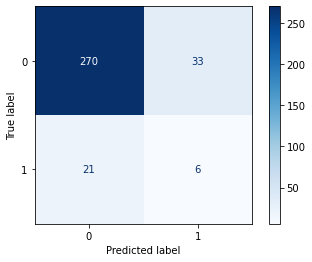

In [46]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,1,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
X_test_1 = X_test_1.drop('HOMA',axis = 1)
X_test_1 = X_test_1.drop('Insulin',axis = 1)
X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)

#impute

X_test_1 = X_test_1.fillna(X_train_1.median())
newX_test_1 = np.concatenate((X_test_1, Prob_test_1[:,None]), axis=1)

y_pred_test_1 = rf_22.predict(newX_test_1)
y_pred_test_prob_1 = rf_22.predict_proba(newX_test_1) #Probabilidad de pertenecer a cada clase

plot_confusion_matrix(rf_22,newX_test_1,y_test,cmap=plt.cm.Blues)

plt.show()

In [47]:
print(y_pred_test_prob[:,1])

[0.27541232 0.31469664 0.68501068 0.21592595 0.31328755 0.18320516
 0.23691026 0.48048401 0.32093283 0.77187056 0.23910063 0.24718612
 0.2265716  0.22942077 0.77813314 0.25200299 0.20479059 0.24813933
 0.24026249 0.2137694  0.27580923 0.27156766 0.71263305 0.22998207
 0.26812337 0.28170973 0.21389858 0.23037    0.26524    0.25264477
 0.22884274 0.2459233  0.24277749 0.20398187 0.18267374 0.26330978
 0.28411843 0.25511043 0.22156446 0.71943031 0.25082637 0.19681987
 0.7441652  0.19269534 0.23107614 0.26353402 0.30394765 0.1895631
 0.24812717 0.2695876  0.25456081 0.25676969 0.32521452 0.26284473
 0.19548684 0.34787307 0.26693632 0.23455678 0.28358269 0.28063719
 0.29938929 0.48508935 0.75782589 0.22272408 0.25571086 0.23450026
 0.25582691 0.79256227 0.29968034 0.25977701 0.31976046 0.29164989
 0.22642514 0.26495699 0.22379924 0.2416857  0.26472289 0.2792904
 0.20587286 0.33969337 0.30480993 0.24322823 0.72286112 0.28582947
 0.26009653 0.18966966 0.72830226 0.2977658  0.24687361 0.236476

[[276  27]
 [ 23   4]]
Accuracy :  0.8484848484848485
Sensitivity :  0.14814814814814814
Specificity :  0.9108910891089109


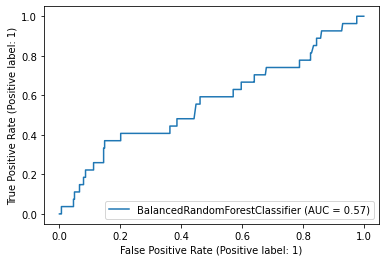

In [48]:
cm1 = confusion_matrix(y_test,y_pred_test)
print(cm1)

total1=sum(sum(cm1))

accuracy1=(cm1[0,0]+cm1[1,1])/np.sum(cm1)
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_test_1, y_test)
plt.show()